In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

from PIL import Image

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from random import randint

from utils import EmotionClassifier

In [2]:
emotions = [
    'angry',
    'disgust',
    'fear',
    'happy',
    'neutral',
    'sad',
    'surprise'
]

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, emotions, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.images = []
        self.labels = []

        for i, emotion in enumerate(emotions):
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.isdir(emotion_dir):  # Ensure it's a directory
                for image_name in os.listdir(emotion_dir):
                    image_path = os.path.join(emotion_dir, image_name)
                    self.images.append(image_path)
                    self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('L')  # Open as grayscale
        # image = Image.open(image_path).convert('RGB')  # Open as RGB
        # Convert to tensor
        image = transforms.ToTensor()(image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Define constants
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.002
NUM_CLASSES = 7
ROOT_DIR = './images'  # Adjust based on your dataset structure

# Define data transformations

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),  # Resize to the target dimensions
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally
    # transforms.RandomRotation(degrees=15),  # Rotate randomly within 15 degrees
    # transforms.RandomResizedCrop(size=48, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly change brightness, contrast, saturation, hue
    # transforms.RandomVerticalFlip(p=0.5),  # 50% chance to flip vertically (optional)
    transforms.ToTensor(),  # Convert to tensor before applying RandomErasing
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),  # Randomly erase parts of the image
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

# Initialize datasets and dataloaders
train_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'train'), emotions=emotions, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'validation'), emotions=emotions, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
class_counts = {
    0: 3993,  # angry
    1: 436,   # disgust
    2: 4103,  # fear
    3: 7164,  # happy
    4: 4982,  # neutral
    5: 4938,  # sad
    6: 3205   # surprise
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

# Calculate class weights as the inverse of the frequency
class_weights = {label: total_samples / (num_classes * count) for label, count in class_counts.items()}
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32)

In [ ]:
# Initialize the model, loss function, and optimizer
model = EmotionClassifier(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Check if GPU is available
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Use tqdm to create a progress bar for training
    with tqdm(total=len(train_loader), desc=f'Training Epoch {epoch + 1}/{NUM_EPOCHS}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))  # Update loss in the progress bar
            pbar.update(1)  # Increment the progress bar

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}')

    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Use tqdm to create a progress bar for validation
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.update(1)  # Increment the progress bar

    # Calculate accuracy
    accuracy = correct / total
    scheduler.step(accuracy)
    
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

print('Training Complete!')

Training Epoch 1/50: 100%|██████████| 451/451 [00:20<00:00, 21.74batch/s, loss=1.82]


Epoch [1/50], Loss: 1.8241


Validation: 100%|██████████| 111/111 [00:03<00:00, 33.94batch/s]


Validation Accuracy: 39.24%


Training Epoch 2/50:  61%|██████    | 276/451 [00:12<00:07, 22.82batch/s, loss=1.75]


KeyboardInterrupt: 

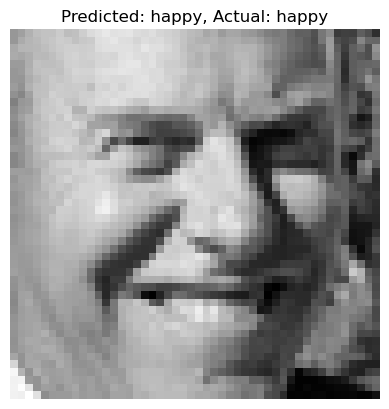

In [ ]:
# make new predictions
model.eval()
test_dataset = EmotionDataset(root_dir=os.path.join(ROOT_DIR, 'validation'), emotions=emotions, transform=transform)

r = randint(0, len(test_dataset) - 1)

# Select a random image from the dataset
image, label = test_dataset[r]
image = image.unsqueeze(0).to(device)

# Perform a forward pass
output = model(image)
_, predicted = torch.max(output.data, 1)

plt.figure()
plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title(f'Predicted: {emotions[predicted.item()]}, Actual: {emotions[label]}')
plt.show()

In [ ]:
torch.save(model.state_dict(), './model.pth')